# Lending Club loans dataset

## Objective

* Create ML model to predict probability of default on LC dataset

* Group loans into risk bins that are similar to original LC sub-grade classification

* Compare classifications

* Estimate required interest rates for new risk groups

* Compare rates

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.optimize as opt
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay

from category_encoders import TargetEncoder

import xgboost as xgb
import shap

from numba import njit

C:\Users\HP\notebooks\Turing\M3CAP\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PREP

* Original dataset: https://www.kaggle.com/datasets/wordsforthewise/lending-club

* I already dropped columns that are for joint application loans or are known after loan issue

In [2]:
loans = pd.read_parquet('loans_reduced.parquet')

In [3]:
loans.shape

(2260668, 95)

## Nan fill

* Apply different strategies to columns

In [4]:
nans = loans.isna().sum() / loans.shape[0]
nans[nans>0.01].sort_values().to_frame().style.format(precision=2)

,0
total_bc_limit,0.02
total_bal_ex_mort,0.02
acc_open_past_24mths,0.02
mort_acc,0.02
num_sats,0.03
num_bc_sats,0.03
mo_sin_rcnt_tl,0.03
num_accts_ever_120_pd,0.03
total_rev_hi_lim,0.03
num_actv_bc_tl,0.03


In [5]:
max_list = ['mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 
            'mths_since_recent_revol_delinq', 'mths_since_rcnt_il', 'mths_since_recent_inq', 
            'pct_tl_nvr_dlq','mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_recent_bc']

min_list = ['il_util', 'all_util', 'open_acc_6m', 'inq_last_12m', 'open_act_il', 
            'max_bal_bc', 'open_rv_12m', 'open_il_24m', 'open_il_12m', 
            'open_rv_24m', 'inq_fi', 'total_bal_il', 'num_tl_120dpd_2m',
            'bc_util', 'percent_bc_gt_75', 'avg_cur_bal', 'num_rev_accts', 
            'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_actv_bc_tl',
            'num_tl_op_past_12m', 'num_il_tl', 'num_bc_tl', 'num_op_rev_tl', 
            'num_rev_tl_bal_gt_0', 'num_actv_rev_tl', 'tot_cur_bal', 'num_accts_ever_120_pd', 
            'tot_coll_amt', 'num_sats', 'num_bc_sats', 'acc_open_past_24mths', 
            'total_bal_ex_mort', 'mort_acc', 'revol_util']

median_list = ['total_cu_tl', 'mo_sin_old_il_acct', 'bc_open_to_buy', 'mo_sin_old_rev_tl_op', 
               'total_il_high_credit_limit', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'total_bc_limit', 'dti', 'emp_length']

In [6]:
loans.loc[:, max_list] = loans.loc[:, max_list].fillna(loans[max_list].max()+1)

loans.loc[:, min_list] = loans.loc[:, min_list].fillna(0)

loans.loc[:, median_list] = loans.loc[:, median_list].fillna(loans[median_list].median())

## Feature mods

* Combine multiple features into one to represent most important information

* Add percentage features

In [7]:
recent_acc = ['num_tl_op_past_12m', 'open_acc_6m', 'acc_open_past_24mths']
due_acc = ['num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m']
old_acc = ['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op']
last_acc = ['mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_inq']
last_delinq = ['mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 
               'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']
choffs = ['chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs']
pub_rec = ['pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'num_accts_ever_120_pd']

In [8]:
# weighted most recent account
loans.loc[:, 'rec_acc'] = loans['num_tl_op_past_12m'] * 2\
+loans['open_acc_6m'] * 3 + loans['acc_open_past_24mths']

# weighted recent delinquencies
loans.loc[:, 'due_acc'] = loans['num_tl_120dpd_2m'] * 3 \
+ loans['num_tl_90g_dpd_24m'] +\
loans['num_tl_30dpd'] * 2

# months since any oldest account
loans.loc[:, 'old_acc'] = np.max(loans.loc[:, old_acc], axis=1)

# months since any latest account
loans.loc[:, 'last_acc'] = np.min(loans.loc[:, last_acc], axis=1)

# months since latest delinquency
loans.loc[:, 'last_delinq'] = np.min(loans.loc[:, last_delinq], axis=1)

# total number of delinquencies and charge-offs
loans.loc[:, 'choffs'] = np.sum(loans.loc[:, choffs], axis=1)

# total number of public records
loans.loc[:, 'tot_rec'] = np.sum(loans.loc[:, pub_rec], axis=1)

# percentage satisfactory accounts
loans.loc[:, 'sats_perc'] = loans.num_sats / loans.total_acc

# opened acc recent from total
loans.loc[:, 'rec_acc_perc'] = loans.num_tl_op_past_12m / loans.total_acc

# inq recent from total
loans.loc[:, 'rec_inq_perc'] = loans.inq_last_12m / loans.inq_fi

# open from total perc
loans.loc[:, 'open_perc'] = loans.open_acc / loans.total_acc

# loan amnt to income 
loans.loc[:, 'lti'] = loans.funded_amnt / loans.annual_inc

In [9]:
# fill nans of new features
loans.loc[:, 'rec_inq_perc'] = loans.loc[:, 'rec_inq_perc'].replace(np.inf, 0)
loans.loc[:, 'rec_inq_perc'] = loans.loc[:, 'rec_inq_perc'].fillna(0)

In [10]:
rem_cols = due_acc + last_acc + last_delinq + choffs + old_acc + pub_rec
# drop reduced cols
loans = loans.loc[:, ~loans.columns.isin(rem_cols)]
loans = loans.dropna()

In [11]:
loans.shape

(2259946, 85)

# Model

* Train on expired loans issued since 2013

* Target encoded categorical features: `purpose`, `home_ownership`, `verification_status`

* Train Xgboost tree model on GPU

In [12]:
# filter to expired loans issued since 2013
loans = loans.loc[(loans.months_rem<0) & (loans.issue_d>'2013')]

In [13]:
loans.shape

(633196, 85)

In [14]:
# known after loan issue, used to compare rates
payments = [
    'int_rate',
    'total_rec_int', 'total_rec_prncp',
    'total_pymnt', 'total_pymnt_inv',
    'out_prncp', 'out_prncp_inv', 
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_amnt']

In [15]:
# helper cols not used in training
extra = ['grade', 'sub_grade', 'issue_d', 'quarter', 'last_credit_pull_mths', 'months_rem']

In [16]:
# prepare train and test samples
X = loans.loc[:, ~loans.columns.isin(payments + extra + ['choff'])]
X = X.replace(np.inf, 0)

y = loans.choff

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2)

encoder = TargetEncoder()
target_enc = ['purpose', 'home_ownership', 'verification_status']
X_train[target_enc] = encoder.fit_transform(X_train[target_enc], y_train)
X_test[target_enc] = encoder.transform(X_test[target_enc])

dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
dtest = xgb.DMatrix(data=X_test, label=y_test, feature_names=X.columns)

In [17]:
X_train.shape

(506556, 68)

## Model config

In [18]:
config = {
    'eta': 0.01,
    'max_depth': 5, 
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric': 'logloss',
    'scale_pos_weight': 1.0, 
    'colsample_bytree': 0.7, 
    'subsample': 0.7,
    'reg_lambda': 50,
    'gamma': 10,
    'min_child_weight': 10}

In [19]:
# model train
bst = xgb.train(config, dtrain, num_boost_round=5000, 
                evals=[(dtrain, 'train'), (dtest, 'eval')], 
                early_stopping_rounds=10, verbose_eval=0)

## Model eval

In [20]:
y_pred_proba = bst.predict(dtest)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logl = log_loss(y_test, y_pred_proba)
print('ROC AUC: ', roc_auc)
print('Logloss: ', logl)

ROC AUC:  0.6945046935342196
Logloss:  0.38929819932267107


### Probability calibration

* Calibrated probability will allow classifying loans into risk bins


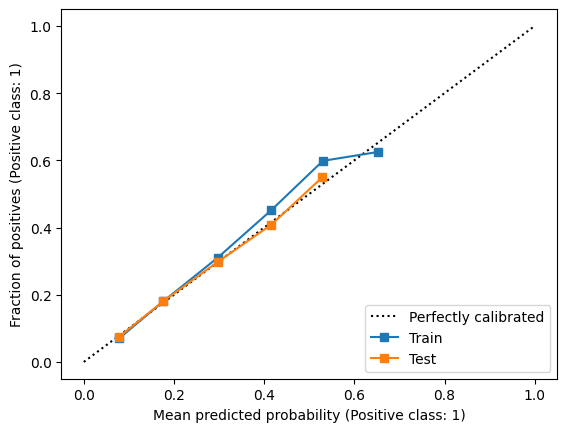

In [21]:
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(y_train, bst.predict(dtrain), strategy='uniform', n_bins=8, ax=ax, name='Train')
CalibrationDisplay.from_predictions(y_test, bst.predict(dtest), strategy='uniform', n_bins=8, ax=ax, name='Test')


### Probability distribution

* Predicted probabilities are more left-skewed than LC sub-grade loan count would suggest

Text(0.5, 1.0, 'LC sub-grade loan count')

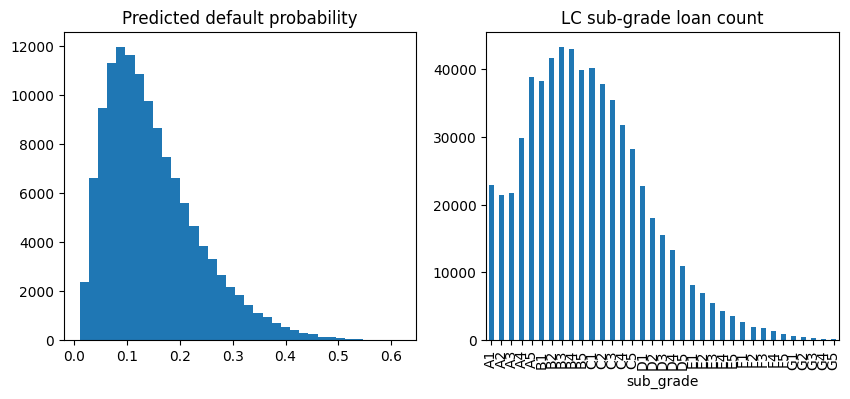

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(y_pred_proba, bins=35);
ax[0].set_title('Predicted default probability')
loans.groupby('sub_grade').choff.count().plot.bar(ax=ax[1])
ax[1].set_title('LC sub-grade loan count')

### SHAP values

* Most impactful features on model results

In [23]:
shap_values_xgb = bst.predict(dtrain, pred_contribs=True)

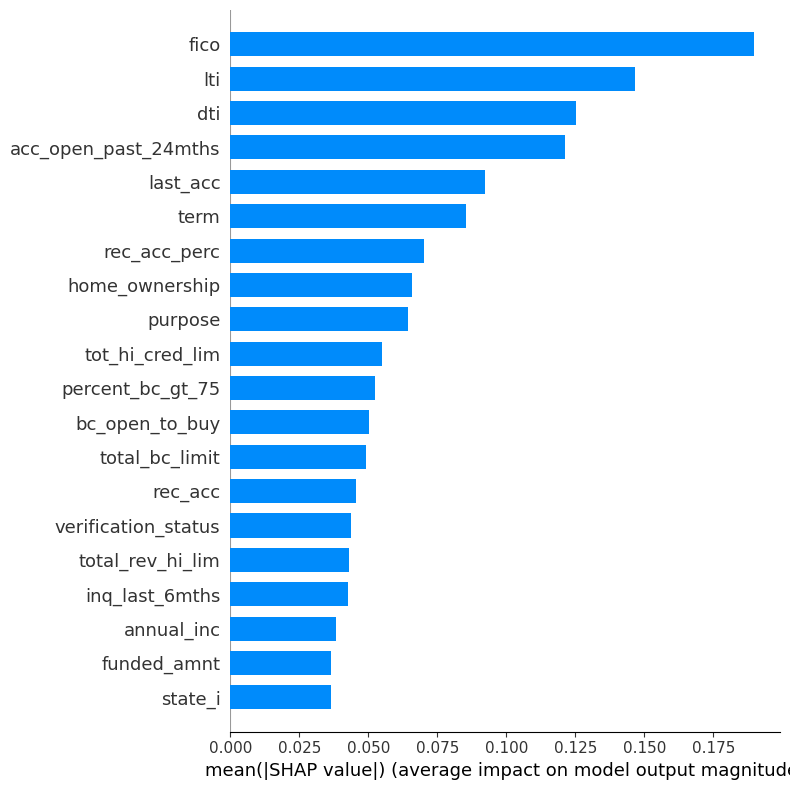

In [24]:
shap.summary_plot(
    shap_values_xgb[:, :-1], X_train, 
    feature_names=dtrain.feature_names, plot_type="bar",
    plot_size=(8, 8))

### All SHAP values

In [25]:
pd.DataFrame(
    data=np.abs(shap_values_xgb[:, :-1]).sum(axis=0), 
    index=dtrain.feature_names)\
.sort_values(0)[::-1].style.format()

,0
fico,96043.914062
lti,74315.515625
dti,63514.324219
acc_open_past_24mths,61439.007812
last_acc,46825.003906
term,43257.050781
rec_acc_perc,35527.753906
home_ownership,33314.363281
purpose,32683.675781
tot_hi_cred_lim,27835.013672


In [26]:
bst.save_model('xgbooster.json')

# Group loans into risk bins

* LC loans classified into 7 grades [A, B, C, D, E, F, G] and them each grade into 5 sub-grades [1, 2, 3, 4, 5]

* Try to replicate that but with 25 risk bins instead of 35

In [27]:
# train sample risk prediction
y_pred_train = bst.predict(dtrain)

In [28]:
# add predicted prob to train sample
loans_train = loans.loc[X_train.index]
loans_train.loc[:, 'proba'] = y_pred_train

In [29]:
loans_test = loans.loc[X_test.index]
loans_test.loc[:, 'proba'] = y_pred_proba

## Grade bins

* Set width to make grade sizes similar to LC

In [30]:
sbins = [
    0, 
    0.04, 0.05, 0.06, 0.07, 0.08,
    0.09, 0.10, 0.115, 0.13, 0.145,
    0.16, 0.18, 0.20, 0.22, 0.24,
    0.26, 0.28, 0.30, 0.32, 0.34, 
    0.36, 0.38, 0.4, 0.42, 1.0]

gbins = [0, 0.08, 0.145, 0.24, 0.34, 1.0]

In [31]:
grade_labels = ['A', 'B', 'C', 'D', 'E']
# sub-grade labels
labels = []
for i in grade_labels:
    for j in range(1, 6):
        labels.append(i+str(j))

In [32]:
# train sample sub-grade labels
subcut = pd.cut(loans_train.proba, sbins, labels=labels)
loans_train['nsub_grade'] = subcut

# train sample grade labels
gcut = pd.cut(loans_train.proba, gbins, labels=grade_labels)
loans_train['ngrade'] = gcut

In [33]:
# test sample labels
subcut = pd.cut(loans_test.proba, sbins, labels=labels)
loans_test['nsub_grade'] = subcut

gcut = pd.cut(loans_test.proba, gbins, labels=grade_labels)
loans_test['ngrade'] = gcut

### Bin sizes

* Number of loans in portfolio

In [34]:
train_size = loans_train.groupby('ngrade').choff.count() / loans_train.shape[0]
train_size.name = 'new_train_grades'
test_size = loans_test.groupby('ngrade').choff.count() / loans_test.shape[0]
test_size.name = 'new_test_grades'

g_size = loans_train.groupby('grade').choff.count() / loans_train.shape[0]
g_size.name = 'lc_grades'
pd.concat([g_size, train_size, test_size], axis=1).style.format(precision=3)

,lc_grades,new_train_grades,new_test_grades
A,0.213,0.235,0.235
B,0.325,0.331,0.331
C,0.274,0.285,0.286
D,0.127,0.113,0.112
E,0.045,0.036,0.036
F,0.013,nan,nan
G,0.002,nan,nan


## Sub-grade actual v predicted default probability

* Predicted probability on train sample slightly underestimates default probability for C4 and above loans

* More work on hyperparameter tuning and feature selection is likely to produce better calibration

In [35]:
train_subg = loans_train.groupby('nsub_grade').apply(lambda x: pd.Series([x.choff.mean(), x.proba.mean()], index=['train_true', 'train_pred']))
train_lcsubg = loans_train.groupby('sub_grade').choff.mean()
train_lcsubg.name = 'train_lc_true'
train_subg = train_subg.join(train_lcsubg, how='right')
test_subg = loans_test.groupby('nsub_grade').apply(lambda x: pd.Series([x.choff.mean(), x.proba.mean()], index=['test_true', 'test_pred']))

<Axes: xlabel='sub_grade'>

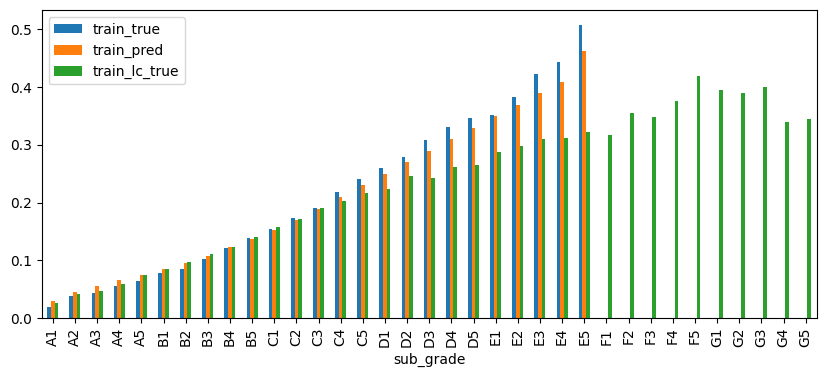

In [36]:
fig, ax = plt.subplots(figsize=(10, 4))
train_subg.plot.bar(ax=ax)

In [37]:
test_subg = loans_test.groupby('nsub_grade').apply(lambda x: pd.Series([x.choff.mean(), x.proba.mean()], index=['test_true', 'test_pred']))
test_lcsubg = loans_test.groupby('sub_grade').choff.mean()
test_lcsubg.name = 'test_lc_true'
test_subg = test_subg.join(test_lcsubg, how='right')

<Axes: xlabel='sub_grade'>

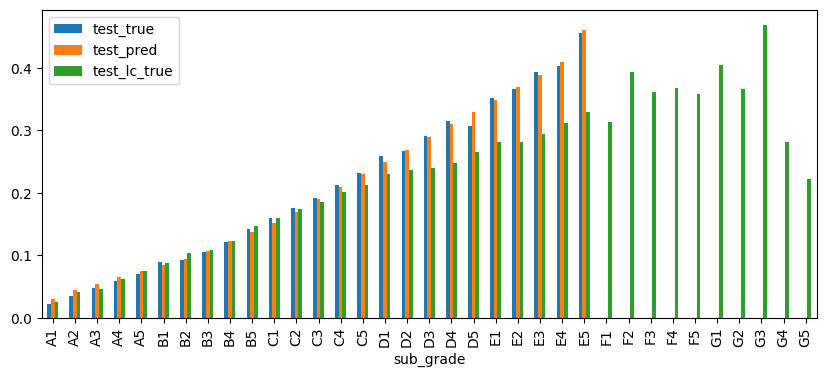

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
test_subg.plot.bar(ax=ax)

### US historic charge-off rates

* Model is trained on a sample of loans that were active during a period of low charge-offs

* Which could be one of the reasons why model resulted in a more left-skewed probability distribution

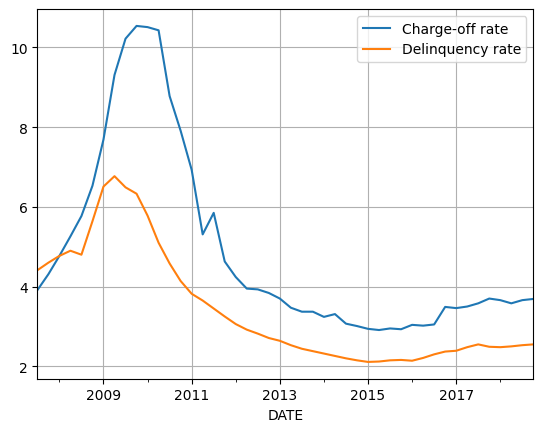

In [39]:
# charge-off rate
cor = pd.read_csv('../CORCCACBS.csv')
cor['DATE'] = pd.to_datetime(cor['DATE'])
cor = cor.groupby(cor.DATE.dt.to_period('M')).CORCCACBS.mean()
cor = cor.loc[(cor.index<'2019') & (cor.index>'2007-06')]
fig, ax = plt.subplots()
cor.plot(ax=ax)
delinq = pd.read_csv('../DRCCLACBS.csv')
delinq['DATE'] = pd.to_datetime(delinq['DATE']).dt.to_period('Q')
delinq = delinq.loc[delinq['DATE']>'2007-06-01']
delinq.set_index('DATE', inplace=True)
delinq.plot(ax=ax)
ax.legend(labels=['Charge-off rate', 'Delinquency rate'])
ax.grid(visible=True, axis='both')

## New sub-grade composition of original LC sub-grades

* Number of LC classification loans in each newly assigned subgrade. 

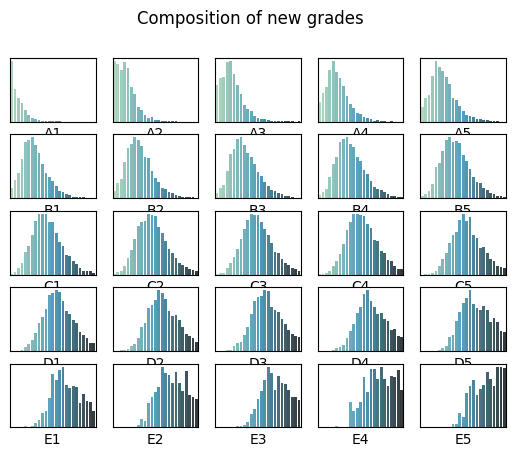

In [40]:
fig, axes = plt.subplots(5, 5)

for ax, label in zip(axes.flatten(), labels):
    sns.countplot(data=loans_test.loc[loans_test.nsub_grade==label], x='sub_grade', order=labels, palette='GnBu_d', ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(label)
    ax.set_ylabel('')
fig.suptitle('Composition of new grades');

In [41]:
# % principal outstanding
loans_train.loc[loans_train.choff==1, 'exposure'] = 1 -\
(loans_train.loc[loans_train.choff==1, ['total_rec_int', 'total_rec_prncp']].sum(axis=1) \
/ loans_train.loc[loans_train.choff==1, 'funded_amnt'])

loans_test.loc[loans_test.choff==1, 'exposure'] = 1 -\
(loans_test.loc[loans_test.choff==1, ['total_rec_int', 'total_rec_prncp']].sum(axis=1) \
/ loans_test.loc[loans_test.choff==1, 'funded_amnt'])

# Setting minimum interest rate

* Find interest rate so that probability of losing money on a loan portfolio is less than 1%

    * $ Pr (S < 0) = 0.01$
    
    * where standard error $SE[S] = \sqrt{np(1-p)}$, 
    
    * loan revenue can be found $x = - l \dfrac{ np  - z \sqrt{np(1-p)}}{n(1-p) + z \sqrt{np(1-p)}}$

    
* Important parameters that are used to estimate rate:

    * `rf` - annuity discount rate, that I arbitrarily set at 4%
    
    * `n` - number of loans in a portfolio, set at 500
    
    * `ead` - principal outstanding at default, estimated from historical data for each grade

In [42]:
@njit
def emi(P, n, r):   
    # equated monthly instalment
    return P * (r * ((1 + r) ** n)) / ((1 + r) ** n - 1)

@njit
def apv(EMI, r, n):
    # annuity present value
    return EMI * (1 - (1 / ((1 + r)**n))) / r

@njit
def npv(P, t, r, rf):
    # net present value of annuity
    EMI = emi(P, t, r)
    APV = apv(EMI, rf, t)
    return -P + APV

In [43]:
def min_rate(x, p, ead_p,  rf):
    """
    Given default rate estimate required interest rate so that
    discounted value of 500 loan portfolio has less than 1% chance of being negative
    """
    P = 1  # principal amnt
    n = 500  # number of loans
    
    z = scipy.stats.norm.ppf(0.01)
    adj = ( n*p - z*np.sqrt(n*p*(1-p)))/ ( n*(1-p) + z*np.sqrt(n*p*(1-p)))
    RR = ead_p * adj  # required return
    
    # scalar optimization to find r
    obj_func = lambda r: np.abs(-RR + npv(P, x.term.values, r/12, rf/12).mean())
    
    res = opt.minimize_scalar(obj_func, method='bounded', bounds=(0.01, 1.0))    
    return res

In [44]:
"""
Estimate interest rate for each newly assigned sub-grade
"""
rf = 0.04  # discount rate annual
rates = {}
# exposure at default
ead = loans_train.groupby('ngrade').exposure.mean()

for k, p in loans_train.groupby('nsub_grade').proba.mean().items():
    slc = loans_train.loc[loans_train.nsub_grade==k]
    ead_p = ead[k[0]]
    rates[k] = min_rate(slc, p, ead_p, rf).x

In [45]:
{k: round(v*100, 1) for k,v in rates.items()}

{'A1': 5.4,
 'A2': 6.0,
 'A3': 6.4,
 'A4': 6.8,
 'A5': 7.1,
 'B1': 7.5,
 'B2': 7.9,
 'B3': 8.4,
 'B4': 9.0,
 'B5': 9.6,
 'C1': 10.3,
 'C2': 11.1,
 'C3': 11.9,
 'C4': 12.8,
 'C5': 13.6,
 'D1': 14.7,
 'D2': 15.6,
 'D3': 16.6,
 'D4': 17.4,
 'D5': 18.4,
 'E1': 19.6,
 'E2': 20.4,
 'E3': 21.4,
 'E4': 22.5,
 'E5': 25.5}

## Compare new rates with original LC rates

* Estimated rates are somewhat similar original LC rates

* Rates offered by LC are also influenced by demand allowing larger premiums

In [46]:
ogrates = loans_test.groupby('sub_grade').int_rate.mean()
nrates = pd.DataFrame.from_dict(rates, orient='index', columns=['nrate'])
rcomp = pd.concat([ogrates/100, nrates], axis=1)
rcomp['d'] = rcomp.nrate - rcomp.int_rate

Text(0.5, 1.0, 'Interest rates')

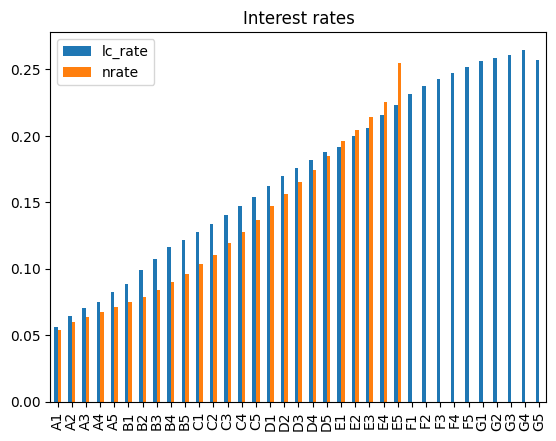

In [47]:
rcomp[['int_rate', 'nrate']].plot.bar()
plt.legend(labels=['lc_rate', 'nrate'])
plt.title('Interest rates')

In [48]:
(rcomp*100).style.format(precision=1)

,int_rate,nrate,d
A1,5.6,5.4,-0.2
A2,6.4,6.0,-0.4
A3,7.1,6.4,-0.7
A4,7.5,6.8,-0.7
A5,8.2,7.1,-1.1
B1,8.9,7.5,-1.3
B2,9.9,7.9,-2.0
B3,10.7,8.4,-2.4
B4,11.7,9.0,-2.7
B5,12.1,9.6,-2.6


## Estimate portfolio returns


* Estimate expected portfolio returns using monte carlo:

    * Draw a sample of `m` loans

    * Simulate random defaults given default rate `p` for each sub-grade
        
    * Estimate expected value of each loan portfolio

* Use `numba` to speed up sims

In [49]:
@njit
def estimate_ev(P, t, m, ead, p, r, rf, n=10000):
    """
    Estimate expected value of loan portfolio given default probability `p`
    t: term
    m: number of loans
    ead: principal outstanding at default
    p: default probability
    r: interest rate applied
    rf: discount rate
    n: number of iters
    
    return: array of simulated returns
    """
    idx = np.arange(t.shape[0], dtype=np.int64)
    ev = np.zeros(n, dtype=np.float32)

    # interest to be collected
    EMI = emi(P, t, r/12)
    APV = apv(EMI, rf, t)    
    NPV = -P + APV

    for i in range(n):
        # draw a sample from all loans
        # using because of varying term
        sample_idx = np.random.choice(idx, m)
        
        # generate random defaults
        survived =  np.random.random(m) >= p
        # losses from defaults
        number_defaults = m - survived.sum()
        losses = number_defaults * ead_p
        # discounted interest from non-defaulted
        profits = NPV[sample_idx][survived].sum()        
        ev[i] = profits - losses
    return ev

In [50]:
def get_portfolio_er(portfolio: dict[str, int], rates: dict[str, float], loan_data: pd.DataFrame):
    """
    Estimate expected value of loan portfolio give number of loans in each sub-grade and corresponding interest rates
    """
    ead = loan_data.groupby('ngrade').exposure.mean()
    
    num_subgrades = len(portfolio.keys())
    
    # number of portfolios
    n = 50000
    # empty result array
    evs = np.zeros((num_subgrades, n), dtype=np.float32)
    
    for i, sub_grade in enumerate(portfolio.items()):
        # number of sub-grade loans
        m = sub_grade[1]
        # historical sub-grade data
        slc = loan_data.loc[loan_data.nsub_grade==sub_grade[0]]
        # sub-grade default prob
        p = slc.proba.mean()
        # principal
        P = 1
        # term
        t = slc.term.values
        # sub-grade interest rate 
        r = rates[sub_grade[0]]
        # sub-grade ead
        ead_p = ead[sub_grade[0][0]]

        evs[i] = estimate_ev(P, t, m, ead_p, p, r, rf, n=n)

    profits = evs.sum(axis=0)

    # probability to earn less than discount rate
    loss_p = profits[profits<0].shape[0] / profits.shape[0]

    # average loss
    loss_avg = profits[profits<0].mean() / sum(portfolio.values())

    # expected return over discount rate
    er = profits.mean() / sum(portfolio.values())

    pnl = pd.DataFrame([loss_p, loss_avg, er], index=['Loss_prob', 'Avg_loss', 'ER']).T

    plt.hist(profits/ sum(portfolio.values()))
    plt.title('Expected returns')

    return [pnl, evs]

In [51]:
# discount rate
rf = 0.04/12

# assuming equal amount invested into each loan
# number of sub-grade loans in a portfolio
portfolio = {
    'A1': 10,
    'A2': 10,
    'A3': 10,
    'A4': 10,
    'A5': 10,
    'B1': 10,
    'B2': 10,
    'B3': 10,
    'B4': 10,
    'B5': 10,
    'C1': 10,
    'C2': 10,
    'C3': 10,
    'C4': 10,
    'C5': 10,
    'D1': 10,
    'D2': 10,
    'D3': 10,
    'D4': 10,
    'D5': 10,
    'E1': 10,
    'E2': 10,
    'E3': 10,
    'E4': 10,
    'E5': 10}


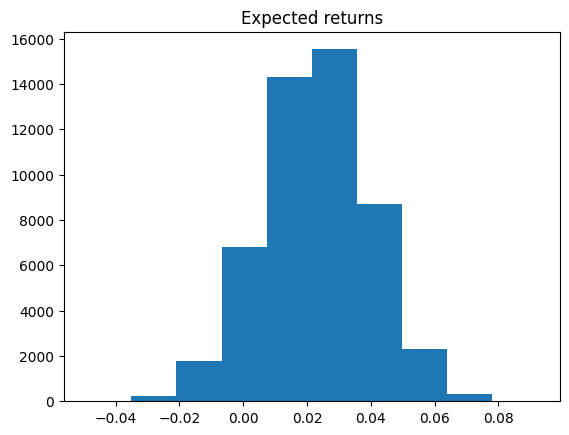

In [52]:
pnl, evs = get_portfolio_er(portfolio, rates, loans_train)

In [53]:
pnl

,Loss_prob,Avg_loss,ER
0,0.08804,-0.007981,0.02291
